# Layer 11

In [4]:
! pip install shap

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import heapq
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import shap
import shap.plots as shap_plots

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Reading Data From CSV files

In [2]:
train_data = pd.read_csv('./train.csv')
valid_data = pd.read_csv('./valid.csv')
test_data = pd.read_csv('./test.csv')

## Extracting X and Y

In [3]:
X_train, y_train = train_data.iloc[:, :-4], train_data.iloc[:, -4:]
X_valid, y_valid = valid_data.iloc[:, :-4], valid_data.iloc[:, -4:]
X_test = test_data.iloc[:, 1:]
y_train_arr = [y_train.iloc[:, i] for i in range(4)]
y_valid_arr = [y_valid.iloc[:, i] for i in range(4)]

# Data Preprocessing

## Checking for missing values

In [4]:
X_train.isnull().sum().sum()

0

In [5]:
X_valid.isnull().sum().sum()

0

In [6]:
X_test.isnull().sum().sum()

0

In [7]:
y_train.isnull().sum()

label_1      0
label_2    480
label_3      0
label_4      0
dtype: int64

In [8]:
y_valid.isnull().sum()

label_1     0
label_2    14
label_3     0
label_4     0
dtype: int64

In [9]:
len(y_train)

28520

Therefore y_train and y_valid label 2 only have missing values

In [10]:
print(f"Missing values percentage of train label 2 column : {y_train_arr[1].isnull().sum()*100/len(y_train)}%")
print(f"Missing values percentage of valid label 2 column : {y_valid_arr[1].isnull().sum()*100/len(y_valid)}%")

Missing values percentage of train label 2 column : 1.6830294530154277%
Missing values percentage of valid label 2 column : 1.8666666666666667%


Since the missing values percentage of train data label 2 column and valid data label 2 column are low, missing values are deleted

In [11]:
train_data_missing_removed = train_data.dropna()
valid_data_missing_removed = valid_data.dropna()
train_data_missing_removed.reset_index(drop=True, inplace=True)
valid_data_missing_removed.reset_index(drop=True, inplace=True)
X_train, y_train = train_data.iloc[:, :-4], train_data.iloc[:, -4:]
X_valid, y_valid = valid_data.iloc[:, :-4], valid_data.iloc[:, -4:]
X_train_missing_removed, y_train_missing_removed = train_data_missing_removed.iloc[:, :-4], train_data_missing_removed.iloc[:, -4:]
X_valid_missing_removed, y_valid_missing_removed = valid_data_missing_removed.iloc[:, :-4], valid_data_missing_removed.iloc[:, -4:]
X_train_arr = [X_train, X_train_missing_removed, X_train, X_train]
X_valid_arr = [X_valid, X_valid_missing_removed, X_valid, X_valid]
X_test_arr = [X_test, X_test, X_test, X_test]

In [12]:
y_train_arr = [y_train.iloc[:, 0], y_train_missing_removed.iloc[:, 1], y_train.iloc[:, 2], y_train.iloc[:, 3]]
y_valid_arr = [y_valid.iloc[:, 0], y_valid_missing_removed.iloc[:, 1], y_valid.iloc[:, 2], y_valid.iloc[:, 3]]

## Scaling

"RobustScaler" standardizes the data, first using training data to calculate scaling parameters and then applying the same transformation to validation and test datasets for consistent scaling in machine learning modeling.

In [13]:
scaler = RobustScaler()
for i in range(4):
  X_train_arr[i] = pd.DataFrame(data=scaler.fit_transform(X_train_arr[i]), columns=X_train_arr[i].columns)
  X_valid_arr[i] = pd.DataFrame(data=scaler.transform(X_valid_arr[i]), columns=X_valid_arr[i].columns)
  X_test_arr[i] = pd.DataFrame(data=scaler.transform(X_test_arr[i]), columns=X_test_arr[i].columns)

# Data Visualization

In [14]:
def visualize_label(y, title, x_title, y_title='Number of rows'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

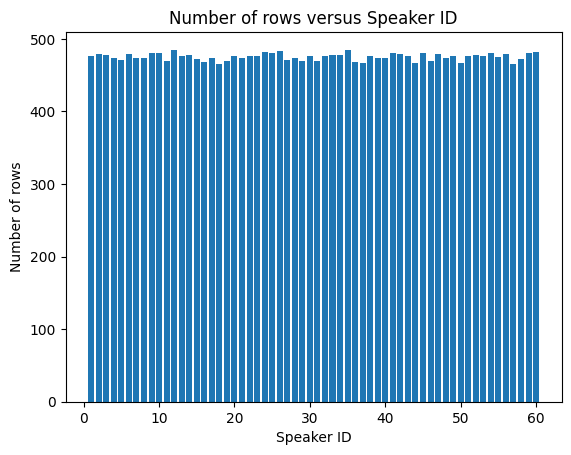

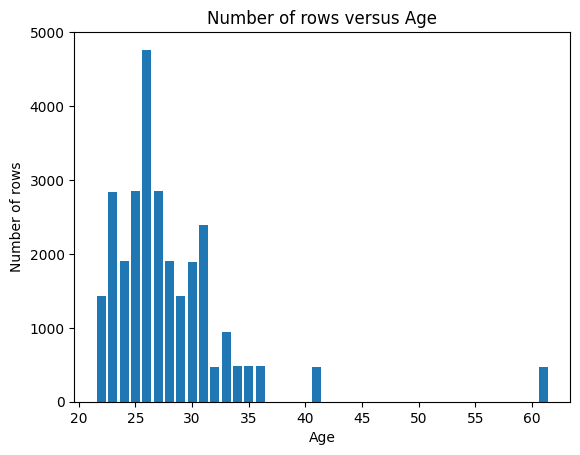

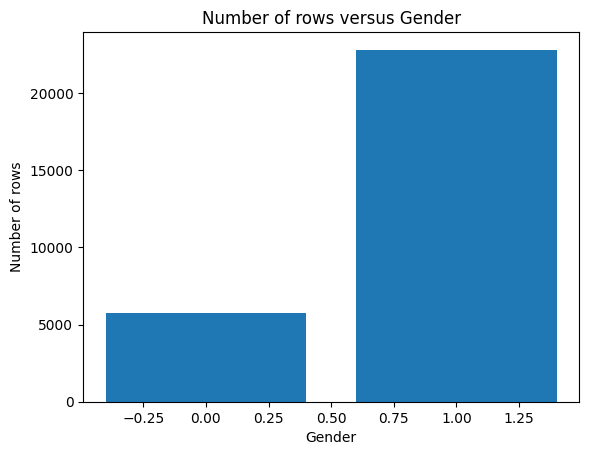

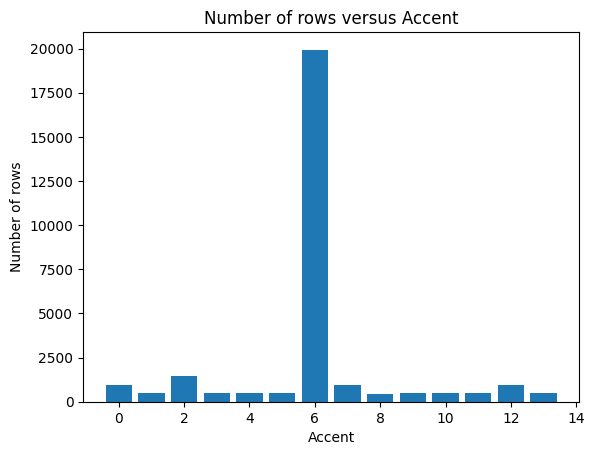

In [15]:
visualize_label(y_train_arr[0], "Number of rows versus Speaker ID","Speaker ID");
visualize_label(y_train_arr[1], "Number of rows versus Age","Age");
visualize_label(y_train_arr[2], "Number of rows versus Gender","Gender");
visualize_label(y_train_arr[3], "Number of rows versus Accent","Accent");

The classes of label 1 are approximately uniformly balanced. In other 3 labes classes are inbalanced. To handle this, class weights are assigned in a latter stage

# Feature Reduction

Principal Component Analysis (PCA) is a tool used to simplify data by reducing its complexity and selecting the most important features. In this context, it's being used to make the features simpler.

In [16]:
def pca_reduce(X,pca, first_fit=False):
  if first_fit:
    X_pca = pca.fit_transform(X)
  else:
    X_pca = pca.transform(X)
  return pd.DataFrame(data=X_pca, columns=[X.columns[i] for i in range(X_pca.shape[1])])

In [17]:
desired_variance_ratio = 0.95
pca = PCA(n_components=desired_variance_ratio, svd_solver='full')
X_train_after_reduction_arr = []
X_valid_after_reduction_arr= []
X_test_after_reduction_arr = []
for i in range(4):
  X_train_after_reduction_arr.append(pca_reduce(X_train_arr[i] ,pca, first_fit=True))
  X_valid_after_reduction_arr.append(pca_reduce(X_valid_arr[i] ,pca))
  X_test_after_reduction_arr.append(pca_reduce(X_test_arr[i] ,pca))

## Useful Functions

In [18]:
def predict(X, model):
  y_pred = model.predict(X)
  return pd.Series(y_pred)

In [19]:
def find_accuracy(y_predicted, y_correct):
  accuracy = accuracy_score(y_predicted, y_correct)
  return accuracy

# Creating models and predicting

Random Forest, kNN and SVC models were considered. After conducting several executions and comparing accuracies SVC models were selected over other two models.

## Random Forest

andom Forest is a practical machine learning approach frequently chosen for its straightforwardness and efficiency in addressing classification tasks.

### Model creating

In [20]:
def random_forest(X, y, n_estimators=100, random_state=42):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, class_weight=class_weight_dict)
    model.fit(X, y)
    return model

In [21]:
random_forest_model_arr = []
for i in range(4):
  random_forest_model_arr.append(random_forest(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [22]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], random_forest_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.7293333333333333
Accuracy score for label 2 : 0.595108695652174
Accuracy score for label 3 : 0.8933333333333333
Accuracy score for label 4 : 0.7266666666666667


## kNN

k-Nearest Neighbors (kNN) is a useful machine learning method often selected for its simplicity and effectiveness in handling classification tasks.

### Model creating

In [23]:
def knn(X, y, n_neighbors=5):
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='uniform')
    model.fit(X, y)
    return model

In [24]:
knn_model_arr = []
for i in range(4):
  knn_model_arr.append(knn(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [25]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], knn_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.8306666666666667
Accuracy score for label 2 : 0.8396739130434783
Accuracy score for label 3 : 0.9866666666666667
Accuracy score for label 4 : 0.9186666666666666


## SVC

Support Vector Classification (SVC) is a machine learning technique used in modeling. It is chosen for its effectiveness in solving classification problems.

### Hyperparameter tuning

The SVM model is tuned using a randomized search approach. Hyperparameter values for 'C', 'gamma', 'kernel' , and 'degree' are explored. RandomizedSearchCV with 100 iterations, 5-fold cross-validation, and parallel processing is applied to find the best combination of hyperparameters for the SVM model.

In [30]:
C = [0.1, 1, 10, 100]
gamma = ['scale', 'auto', 0.001, 0.01, 0.1, 1.0]
kernel = ['linear', 'rbf', 'poly']
degree = [2, 3, 4]
svc_tuning_model = SVC()
param_grid = {
    'C': C,
    'gamma': gamma,
    'kernel': kernel,
    'degree': degree,
}
random_search = RandomizedSearchCV(
    svc_tuning_model,
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=40
)
for i in range(4):
  random_search.fit(X_train_after_reduction_arr[i], y_train_arr[i])
  print(random_search.best_params)

### Model creating

class weights are applied to address the issue of imbalanced classes, ensuring that the model effectively learns from all classes in the dataset.

In [26]:
def svm(X, y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
  model = SVC(kernel='rbf', random_state=40, class_weight=class_weight_dict, C=100)
  model.fit(X, y)
  return model

In [27]:
def svm_linear(X, y):
  class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
  class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}
  model = SVC(kernel='linear', random_state=40, class_weight=class_weight_dict)
  model.fit(X, y)
  return model

In [28]:
svm_model_arr = []
for i in range(4):
  svm_model_arr.append(svm(X_train_after_reduction_arr[i], y_train_arr[i]))

### Predicting for Valid data

In [29]:
y_pred_for_valid_arr = [predict(X_valid_after_reduction_arr[i], svm_model_arr[i]) for i in range(4)]
accuracy_for_valid_data_arr = [find_accuracy(y_pred_for_valid_arr[i], y_valid_arr[i]) for i in range(4)]
for i in range(4):
  print(f"Accuracy score for label {i+1} : {accuracy_for_valid_data_arr[i]}")

Accuracy score for label 1 : 0.96
Accuracy score for label 2 : 0.9320652173913043
Accuracy score for label 3 : 0.9973333333333333
Accuracy score for label 4 : 0.9653333333333334


# Evaluating

## Cross Validation

This computes and displays the cross-validation scores for each of the four SVM models for their respective labels.

In [35]:
for i in range(4):
  scores = cross_val_score(svm_model_arr[i],X_train_after_reduction_arr[i], y_train_arr[i], cv=5)
  print(f"Cross validations scores for label {i} : {scores}")

Cross validations scores for label 0 : [0.917777   0.92268583 0.91830295 0.91497195 0.91532258]
Cross validations scores for label 1 : [0.41690442 0.625      0.65870185 0.65691869 0.4646933 ]
Cross validations scores for label 2 : [0.96248247 0.99246143 0.98702665 0.97475456 0.99176017]
Cross validations scores for label 3 : [0.89463534 0.88008415 0.88429173 0.89533661 0.85974755]


## Heat Maps of the Confusion Matrixes

 This creates a heatmap representation of a confusion matrix. Then, it calculates and visualizes confusion matrices for different labels: "Speaker ID," "Age," "Gender," and "Accent."

In [30]:
def visualize_confusion(confusion, title):
  plt.figure(figsize=(20, 10))
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(f"Confusion Matrix for {title}")
  plt.show()

In [31]:
confusion_arr = [confusion_matrix(y_valid_arr[i], y_pred_for_valid_arr[i]) for i in range(4)]

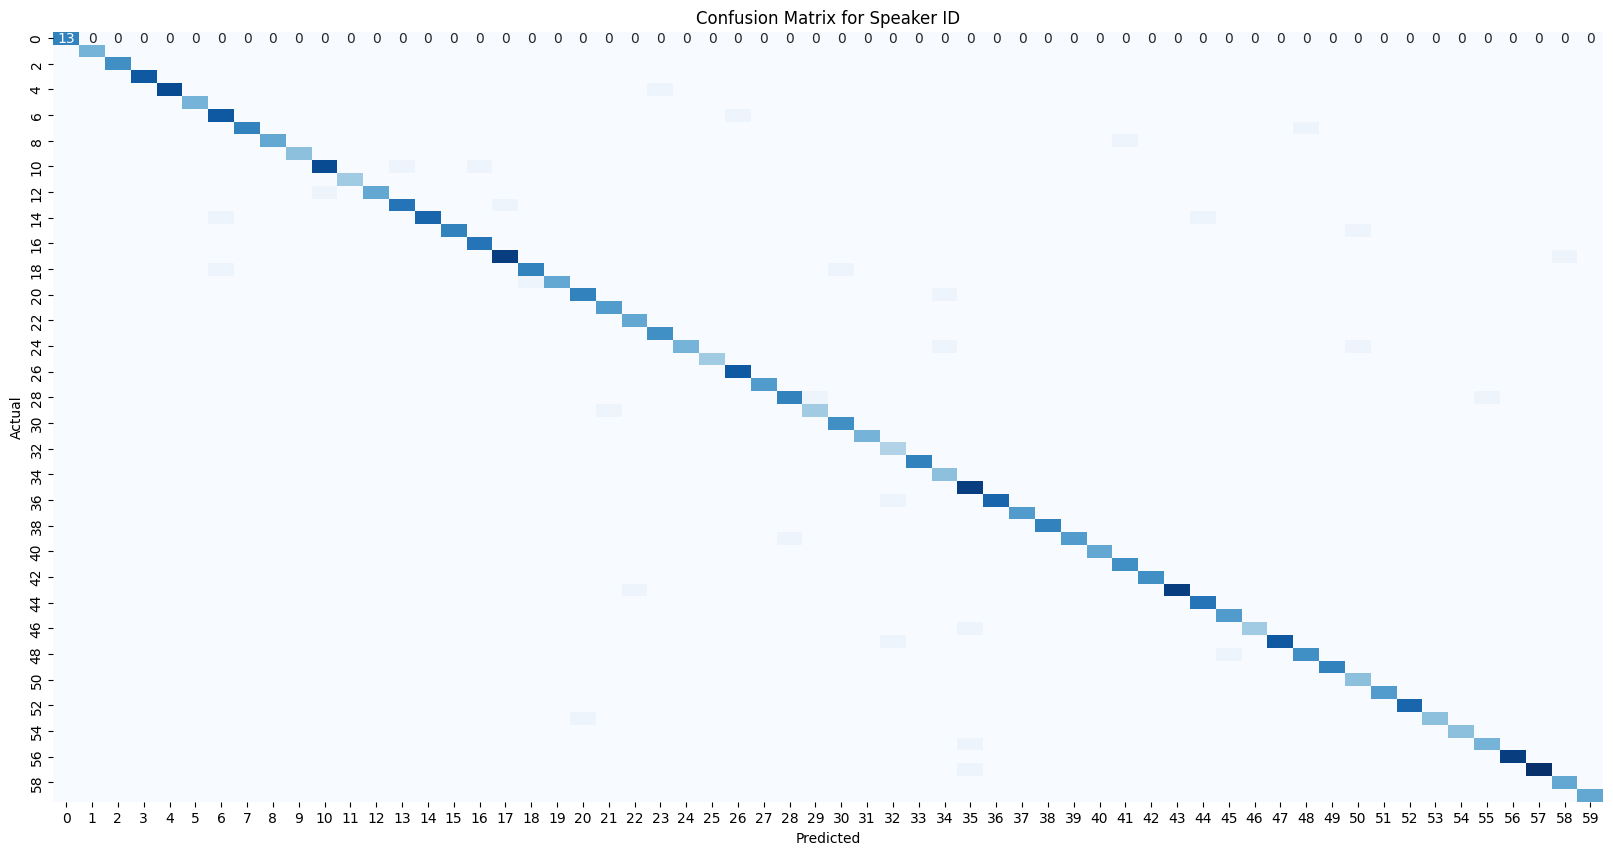

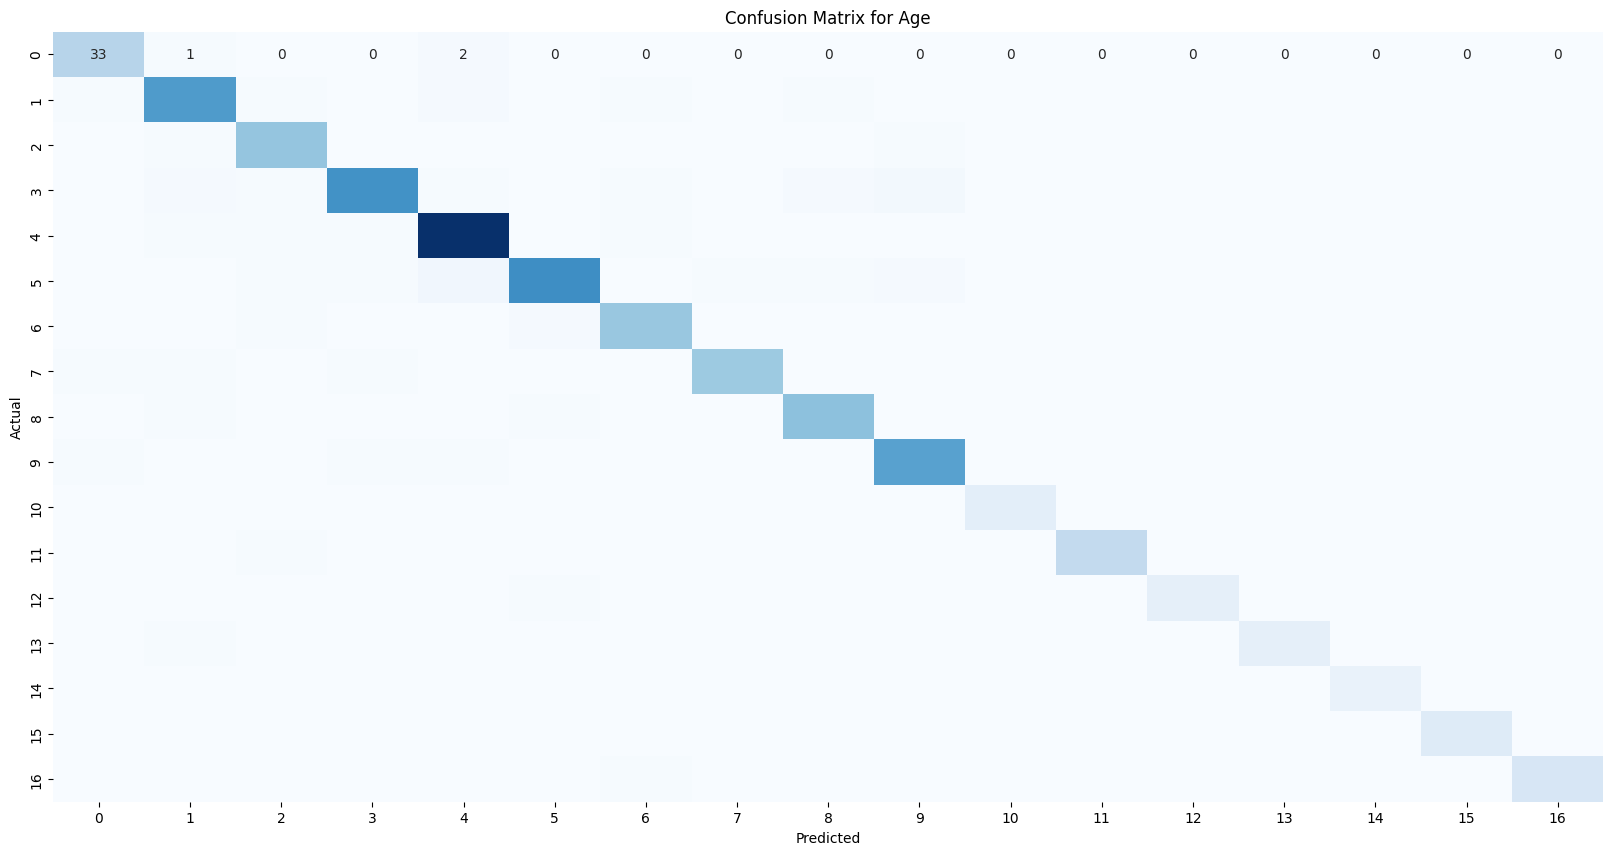

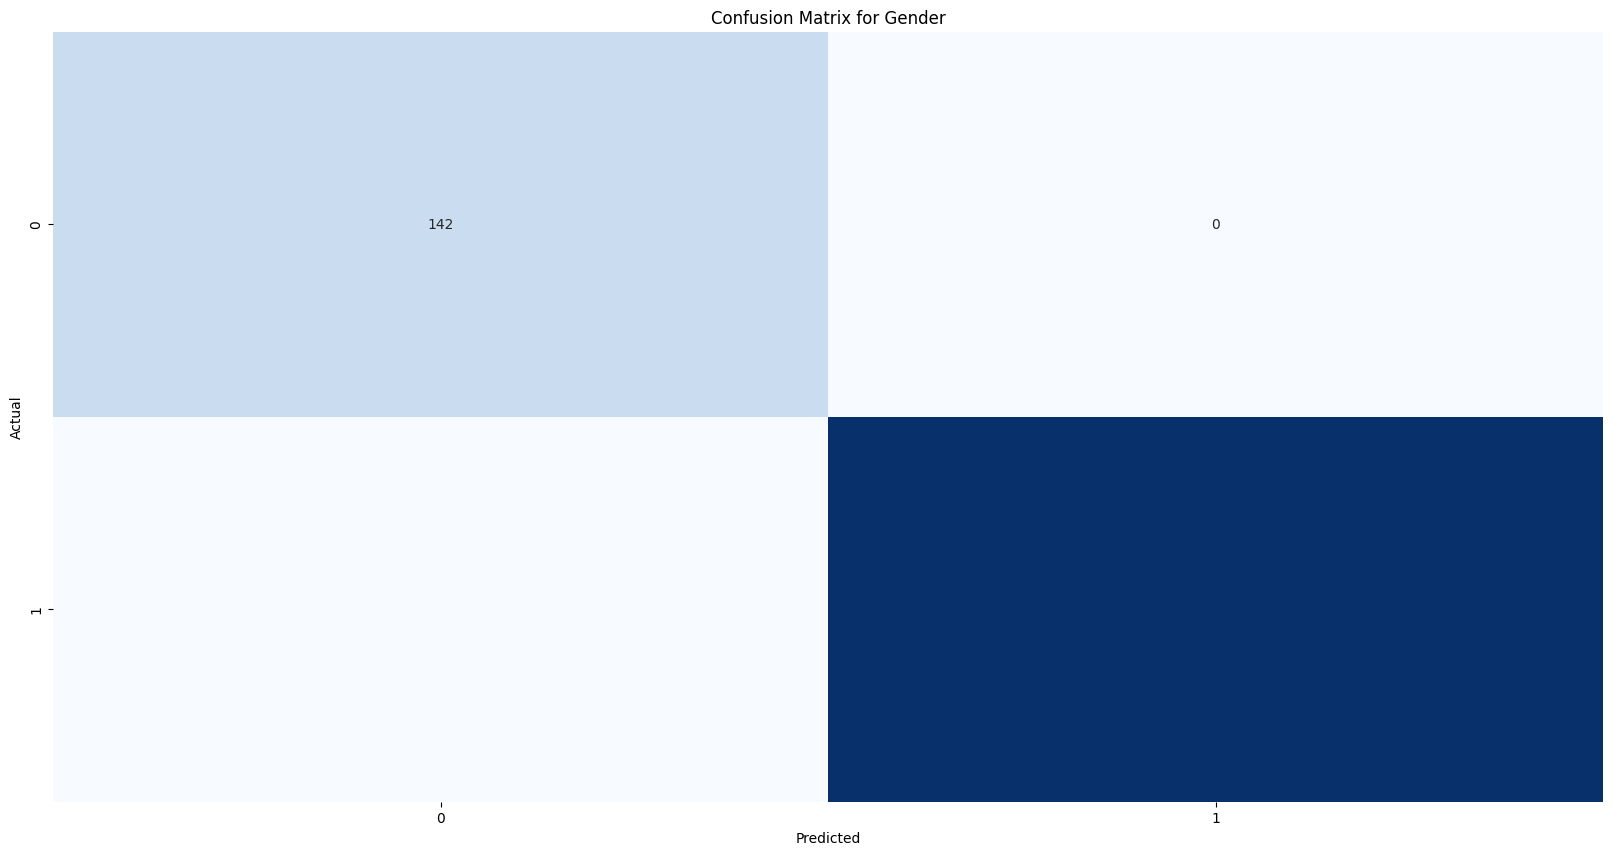

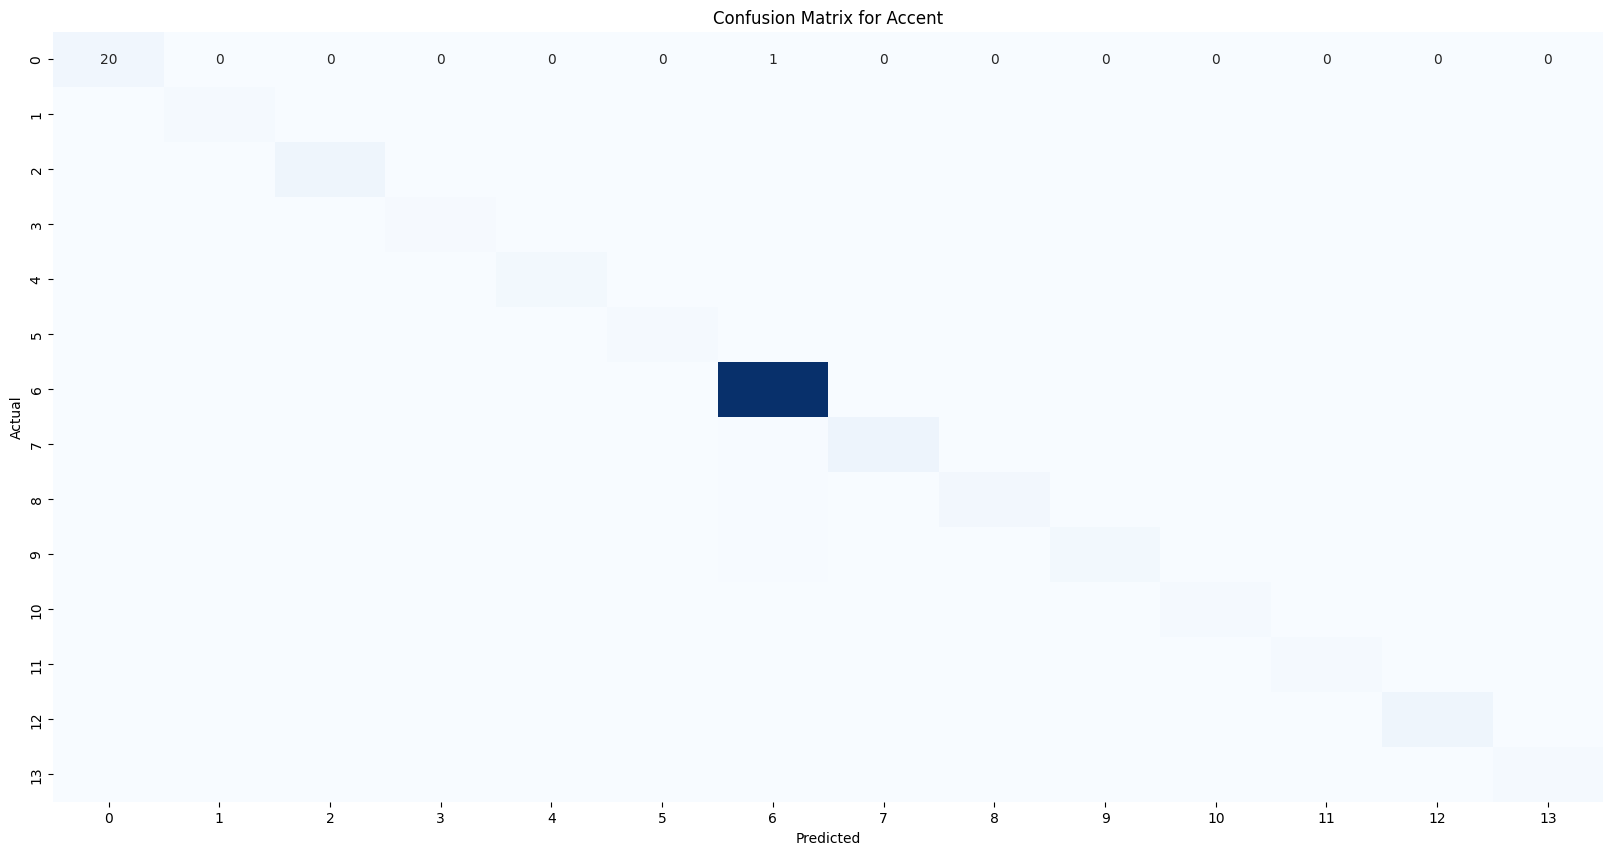

In [32]:
visualize_confusion(confusion_arr[0], "Speaker ID")
visualize_confusion(confusion_arr[1], "Age")
visualize_confusion(confusion_arr[2], "Gender")
visualize_confusion(confusion_arr[3], "Accent")

## Classification Reports

The predictions are generated for validation data using SVM models for four different labels. Then it computes and prints the classification report, including metrics like precision, recall, and F1-score, for each label.

In [33]:
y_pred_for_X_valid_arr = []
accuracy_for_valid_data_arr = []
for i in range(4):
  y_pred_for_X_valid_arr.append(predict(X_valid_after_reduction_arr[i], svm_model_arr[i]))
  accuracy_for_valid_data_arr.append(find_accuracy(y_pred_for_X_valid_arr[i], y_valid_arr[i]))
  print(f"Classification Report for Label {i+1}")
  print(classification_report(y_valid_arr[i], y_pred_for_X_valid_arr[i]))
  print()


Classification Report for Label 1
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        16
           5       1.00      0.94      0.97        18
           6       1.00      1.00      1.00         9
           7       0.89      0.94      0.91        17
           8       1.00      0.93      0.96        14
           9       1.00      0.91      0.95        11
          10       1.00      1.00      1.00         8
          11       0.94      0.89      0.92        19
          12       1.00      1.00      1.00         7
          13       1.00      0.91      0.95        11
          14       0.93      0.93      0.93        15
          15       1.00      0.88      0.94        17
          16       1.00      0.93      0.96        14
          17       0.93      1.00      0.97    

## Accuracies for valid data

In [34]:
for i in range(4):
  print(f"Label {i+1} accuracy for valid data : {accuracy_for_valid_data_arr[i]}")

Label 1 accuracy for valid data : 0.96
Label 2 accuracy for valid data : 0.9320652173913043
Label 3 accuracy for valid data : 0.9973333333333333
Label 4 accuracy for valid data : 0.9653333333333334


# Explainability (Interpreting the label predictions and any cross-relations with labels)

Explaning rbf kernel SVM models are complex. Therefore, to describe the explainability, the linear kernel SVC models are used.

In [35]:
svm_linear_model_arr = [svm_linear(X_train_after_reduction_arr[i], y_train_arr[i]) for i in range(4)]

## SHAP

SHAP is a framework and a set of techniques used in machine learning to explain the predictions made by complex models, such as SVM.

In [ ]:
for i in range(4):
  explainer = shap.Explainer(svm_linear_model_arr[i], X_train_after_reduction_arr[i])
  instance_index = 0
  shap_values = explainer.shap_values(X_test_after_reduction_arr[i])
  shap.summary_plot(shap_values, X_test_after_reduction_arr[i])
  shap.summary_plot(shap_values)

However, due to the high RAM usage of shap.summary_plot and to the complexity, using SHAP was not very effective.

## Using weights assigned to the features

SVC.coef_ are weights assigned to the features when kernel="linear".

In [43]:
def print_top_weight_features(svm_model, n_classes):
  coefficients = svm_model.coef_
  top_weights = []
  for class_A in range(n_classes):
    for class_B in range(class_A + 1, n_classes):
        index = int(class_A * (2 * n_classes - class_A - 1) / 2 + class_B - class_A - 1)
        for feature_index, weight in enumerate(coefficients[index]):
            absolute_weight = np.abs(weight)
            if len(top_weights) < 20:
                heapq.heappush(top_weights, (absolute_weight, feature_index, class_A, class_B, weight))
            else:
                if absolute_weight > top_weights[0][0]:
                    heapq.heappop(top_weights)
                    heapq.heappush(top_weights, (absolute_weight, feature_index, class_A, class_B, weight))
  values_to_print = []
  for i in range(20):
    values_to_print.insert(0, heapq.heappop(top_weights))
  i = 0
  for (absolute_weight, feature_index, class_A, class_B, weight) in values_to_print:
    print(f"Top {i + 1}: The weight assigned to feature {feature_index} between class {class_A} and class {class_B} is {weight}")
    i+=1

In [44]:
for i in range(4):
  print(f"\nFor the Class label {i+1}")
  print_top_weight_features(svm_linear_model_arr[i], len(y_train_arr[i].unique()))



For the Class label 1


Top 1: The weight assigned to feature 48 between class 36 and class 41 is 0.5734605670982543
Top 2: The weight assigned to feature 144 between class 30 and class 38 is 0.5314219954962592
Top 3: The weight assigned to feature 15 between class 3 and class 30 is -0.5311425843004076
Top 4: The weight assigned to feature 76 between class 35 and class 57 is 0.5240120079592278
Top 5: The weight assigned to feature 21 between class 0 and class 20 is -0.5225308540305139
Top 6: The weight assigned to feature 15 between class 3 and class 54 is -0.5179027174696595
Top 7: The weight assigned to feature 24 between class 32 and class 37 is -0.509898398812197
Top 8: The weight assigned to feature 15 between class 23 and class 46 is 0.5076319208927043
Top 9: The weight assigned to feature 15 between class 9 and class 30 is -0.5062633954803265
Top 10: The weight assigned to feature 21 between class 20 and class 46 is 0.5013931252036179
Top 11: The weight assigned to feature 43 between class 2 and class 

According to the above outputs, for the label 1, features 97, 121, 37, 42 and 144 affects more than other features. For the label 2, features 59, 146, 20, 92 and 119 affects more than other features. For the label 3, features 9, 16, 124, 54 and 27 affects more than other features. For the label 4, features 62, 134, 144, 36 and 62 affects more than other features.

## Using constants in the decision function

SVC.intercept_ are constants in decision function.

In [45]:
def print_top_constants(svm_model, n_classes, binary=False):
  intercept = svm_model.intercept_
  top_constants = []
  for class_A in range(n_classes):
    for class_B in range(class_A + 1, n_classes):
        index = int(class_A * (2 * n_classes - class_A - 1) / 2 + class_B - class_A - 1)
        intercept_value = intercept[index]
        absolute_intercept_value = np.abs(intercept[index])
        if len(top_constants) < 20:
            heapq.heappush(top_constants, (absolute_intercept_value, intercept_value, class_A, class_B))
        else:
            if absolute_intercept_value > top_constants[0][0]:
                heapq.heappop(top_constants)
                heapq.heappush(top_constants, (absolute_intercept_value, intercept_value, class_A, class_B))
  values_to_print = []
  if binary:
     values_to_print.append(top_constants[0])
  else:
    for i in range(20):
      values_to_print.insert(0, heapq.heappop(top_constants))
  i = 0
  for (absolute_intercept_value, intercept_value, class_A, class_B) in values_to_print:
    print(f"Top {i + 1}: Intercept/Constant in the decision function is {intercept_value} between the classes {class_A} and {class_B}")
    i+=1

In [46]:
for i in range(4):
  print(f"\nFor the Class Label {i+1}")
  binary = False
  if i==2:
    binary=True
  print_top_constants(svm_linear_model_arr[i], len(y_train_arr[i].unique()), binary=binary)



For the Class Label 1
Top 1: Intercept/Constant in the decision function is -2.594165206162672 between the classes 25 and 46
Top 2: Intercept/Constant in the decision function is 2.433268950669203 between the classes 0 and 25
Top 3: Intercept/Constant in the decision function is -2.263527514497828 between the classes 21 and 34
Top 4: Intercept/Constant in the decision function is -2.1894150829421144 between the classes 27 and 35
Top 5: Intercept/Constant in the decision function is 2.1111582032554916 between the classes 46 and 57
Top 6: Intercept/Constant in the decision function is 1.9800525299419633 between the classes 35 and 57
Top 7: Intercept/Constant in the decision function is 1.9641142543986858 between the classes 20 and 25
Top 8: Intercept/Constant in the decision function is -1.9499296928074115 between the classes 11 and 35
Top 9: Intercept/Constant in the decision function is 1.9264507417000312 between the classes 23 and 25
Top 10: Intercept/Constant in the decision functio

# Predicting for test data

In [47]:
y_pred_for_X_test_arr = []
for i in range(4):
  y_pred_for_X_test_arr.append(predict(X_test_after_reduction_arr[i], svm_model_arr[i]))

# Creating the solutions csv

In [ ]:
def createCSVOutput(y_arr, filename):
  data = {
    'ID' : list(range(1, y_arr[0].shape[0] + 1)),
    'label_1': y_arr[0],
    'label_2': y_arr[1],
    'label_3': y_arr[2],
    'label_4': y_arr[3]
  }
  df = pd.DataFrame(data)
  df.to_csv(filename, index=False)

In [ ]:
createCSVOutput(y_pred_for_X_test_arr, './output.csv')